In [21]:
# Cell 1: Imports and experiment configuration

import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import StandardScaler


%matplotlib widget
import matplotlib.pyplot as plt

from utility import get_data, glasso

# Experiment configuration
TICKERS = pd.read_csv("tickers_names.csv")['Ticker'].tolist()
START_DATE = "2021-01-01"
END_DATE = "2024-01-01"

random_seed = 42
random_permutation = np.random.RandomState(seed=random_seed).permutation(len(TICKERS))[:100]
TICKERS = [TICKERS[i] for i in random_permutation]

ALPHA = 0.4                     # Graphical Lasso regularization parameter
WINDOW_WEEKS = 3
TRADING_DAYS_PER_WEEK = 5
WINDOW_SIZE = WINDOW_WEEKS * TRADING_DAYS_PER_WEEK  # approx 10 trading days

print("Config loaded.")
print("  n_tickers:", len(TICKERS))
print("  date range:", START_DATE, "->", END_DATE)
print("  WINDOW_SIZE (trading days):", WINDOW_SIZE)

Config loaded.
  n_tickers: 100
  date range: 2021-01-01 -> 2024-01-01
  WINDOW_SIZE (trading days): 15


In [22]:
# Retrieve 1-year daily returns
returns_df = get_data(TICKERS, START_DATE, END_DATE, min_coverage=0.95, fill_nan=False, save=False)

print("\nreturns_df info:")
print("  shape:", returns_df.shape)
print("  columns (tickers):", list(returns_df.columns))
print(returns_df.head())


[*********************100%***********************]  100 of 100 completed


Kept 91 / 100 tickers with >= 95% coverage
Dropped 192 days with missing data; 588 days remain
✅ Retrieved 91 assets over 588 days

returns_df info:
  shape: (588, 91)
  columns (tickers): ['0KFE.IL', 'A', 'AAL.L', 'ACGL', 'ADBE', 'ADSK', 'AEM', 'AFL', 'AGCO', 'AI.PA', 'ALL', 'AMD', 'ARE', 'ATD.TO', 'ATO', 'AV.L', 'BA', 'BEN', 'BNS', 'CA.PA', 'CAH', 'CAT', 'CBA.AX', 'CCI', 'CLX', 'CME', 'CMI', 'CNP', 'D', 'DB1.DE', 'DD', 'DEO', 'DNPLY', 'DSG.TO', 'EBS.VI', 'EMP-A.TO', 'EN.PA', 'EQIX', 'EQNR', 'ETR', 'FAST', 'FE', 'FRE.DE', 'FTS.TO', 'GILD', 'GLE.PA', 'GTN.BE', 'HEI.DE', 'HMC', 'IAG.TO', 'IDXX', 'KER.PA', 'KESKOB.HE', 'KIR.MU', 'LAND.L', 'LOGI', 'MO', 'MSFT', 'MSTR', 'NAB.AX', 'NTRS', 'NVDA', 'O39.SI', 'OBL.F', 'PHIA.AS', 'POOL', 'QBR-B.TO', 'RTX', 'SGSLX', 'SHEL', 'STE', 'SU.PA', 'SWKS', 'TFC', 'TJX', 'TKOMY', 'TMO', 'TXT', 'UBS', 'UCG.MI', 'UDR', 'VMC', 'VRTX', 'VTRS', 'WBC.AX', 'WM', 'WPP', 'WSO', 'WYNN', 'XOM', 'YUM']
Ticker       0KFE.IL         A     AAL.L      ACGL      ADBE     

In [23]:
# Cell 3: Split the returns into fixed 2-week windows

def split_into_windows(returns_df, window_size):
    """
    Split the returns DataFrame into non-overlapping windows
    of length `window_size` along the time axis.
    """
    n_samples = returns_df.shape[0]
    n_windows = n_samples // window_size  # floor division

    windows = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        win = returns_df.iloc[start:end]
        windows.append(win)
    return windows

windows = split_into_windows(returns_df, WINDOW_SIZE)

print("Number of windows:", len(windows))
if len(windows) > 0:
    print("First window shape:", windows[0].shape)
    print("First window date range:", windows[0].index[0].date(), "->", windows[0].index[-1].date())
    print("Last window date range:", windows[-1].index[0].date(), "->", windows[-1].index[-1].date())


Number of windows: 39
First window shape: (15, 91)
First window date range: 2021-01-05 -> 2021-02-02
Last window date range: 2023-11-29 -> 2023-12-21


Sample Var. conditioning: 6.555044838325293e+20
 Glasso Var. conditioning: 9916.397093727002
Sample Var. conditioning: 5.602138569586698e+19
 Glasso Var. conditioning: 5447.228680131569
Sample Var. conditioning: 7.470126119338099e+19
 Glasso Var. conditioning: 5762.4116093560715
Sample Var. conditioning: 1.8038003754732844e+20
 Glasso Var. conditioning: 25850.003252636707
Sample Var. conditioning: 1.0996138593967157e+19
 Glasso Var. conditioning: 1359.5539804184386
Sample Var. conditioning: 1.4985025975965661e+19
 Glasso Var. conditioning: 1751.3154560283922
Sample Var. conditioning: 5.1190011393229344e+20
 Glasso Var. conditioning: 170472.68134223222
Sample Var. conditioning: 1.110169741782776e+19
 Glasso Var. conditioning: 3526.240100757823
Sample Var. conditioning: 6.955018505862107e+18
 Glasso Var. conditioning: 662.3670246234086
Sample Var. conditioning: 9.410119656841564e+18
 Glasso Var. conditioning: 870.9452607459144
Sample Var. conditioning: 8.470372254557084e+19
 Glasso Var. 

C:\Users\nicco\AppData\Local\Temp\ipykernel_6424\953936896.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14, 6))
C:\Users\nicco\AppData\Local\Temp\ipykernel_6424\953936896.py:115: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipympl\backend_nbagg.py:342: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  self.figure.savefig(buf, format='png', dpi='figure')


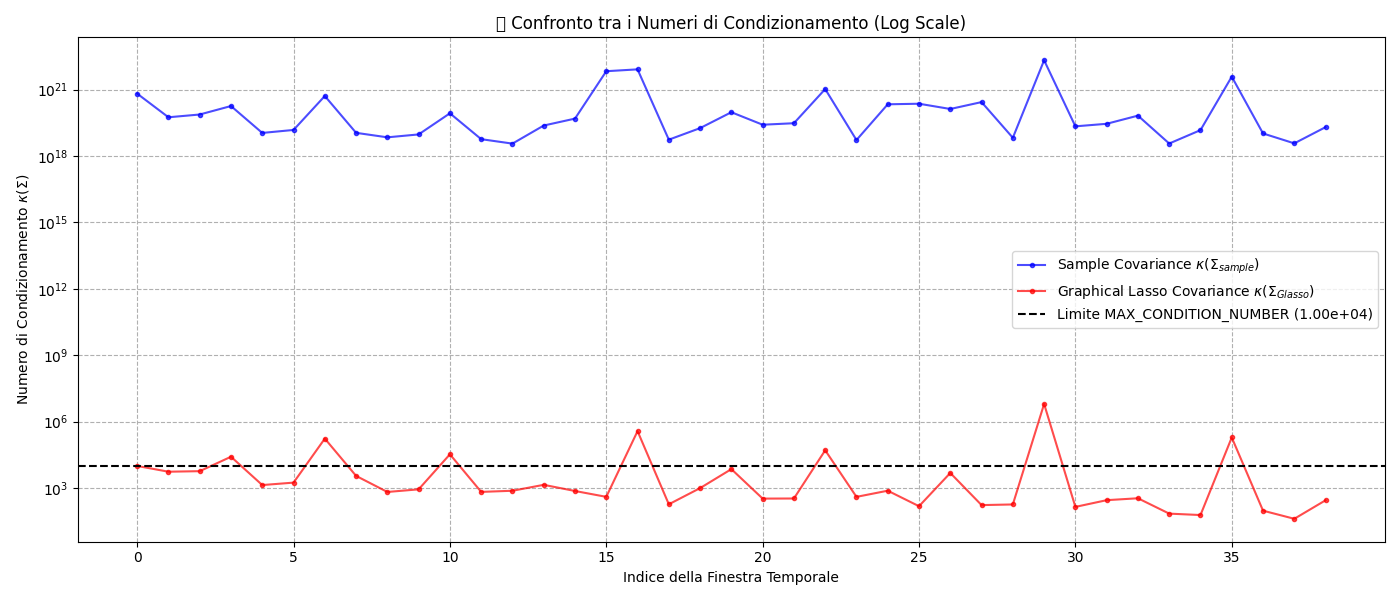


--- Analisi Dettagliata del Condizionamento ---
Limite MAX_CONDITION_NUMBER utilizzato: 1.00e+04
Numero totale di finestre: 39
----------------------------------------
Finestre mal condizionate (Campione): 39 (100.00%)
Finestre mal condizionate (Glasso): 7 (17.95%)


In [24]:
# Cell 4: Covariance and precision estimation per window (sample and Glasso)
# Adds a condition-number check before attempting to invert the sample covariance.

MAX_CONDITION_NUMBER = 1e4  # threshold to consider a matrix "well-conditioned"


def compute_cov_prec_for_window(window_returns, alpha):
    """
    Given a returns window (T x N), standardize it, then:
    - compute the sample covariance of standardized data
    - compute the inverse (precision) of the sample covariance, but only if it is
      sufficiently well-conditioned (based on the condition number)
    - compute a Ledoit–Wolf covariance for input to Graphical Lasso
    - apply Graphical Lasso to obtain a regularized covariance + precision

    Returns
    -------
    sample_cov : (N, N) ndarray
        Sample covariance matrix of standardized returns.
    sample_prec : (N, N) ndarray or None
        Inverse (precision) of sample_cov. Uses pseudo-inverse if poorly conditioned,
        or None if even pseudo-inverse fails.
    glasso_cov : (N, N) ndarray
        Covariance matrix estimated by Graphical Lasso.
    glasso_prec : (N, N) ndarray
        Precision matrix estimated by Graphical Lasso.
    """
    # --- STANDARDIZE RETURNS IN THE WINDOW ---
    scaler = StandardScaler()
    X = scaler.fit_transform(window_returns.values)  # shape: (T, N)

    # --- UNREGULARIZED SAMPLE COVARIANCE ---
    sample_cov = np.cov(X, rowvar=False)  # shape: (N, N)
    s = scaler.scale_
    D = np.diag(s)
    sample_cov = D @ sample_cov @ D

    # --- CONDITION NUMBER CHECK ---
    try:
        cond_sample = np.linalg.cond(sample_cov) # 2-norm, computed directly using the SVD
    except np.linalg.LinAlgError as e:
        print(
            "Warning: could not compute condition number for sample covariance "
            f"in this window. Treating it as ill-conditioned.\n  Details: {e}"
        )
        cond_sample = np.inf

    sample_prec = None
    
    try:
        sample_prec = np.linalg.inv(sample_cov)
    except np.linalg.LinAlgError as e:
        print(
            "Warning:"
            f"(cond={cond_sample:.2e}) and inversion failed;\n"
            f"  Details: {e}"
        )
        sample_prec = None

    # --- GLASSO --- 
    glasso_cov, glasso_prec = glasso(alpha=alpha, returns_df=window_returns, save_outputs=False, max_iter=100)
        
    cond_glasso = np.linalg.cond(glasso_cov)
    
    print(f"Sample Var. conditioning: {cond_sample}\n Glasso Var. conditioning: {cond_glasso}")

    return sample_cov, cond_sample, sample_prec, glasso_cov, cond_glasso, glasso_prec


# Run estimation on all windows
sample_covs = []
sample_precs = []   # list of sample precision matrices (or None)
cond_sample = []
glasso_covs = []
glasso_precs = []   # list of Glasso precision matrices
cond_glasso = []

for idx, win in enumerate(windows):
    s_cov, s_cond, s_prec, g_cov, g_cond, g_prec = compute_cov_prec_for_window(win, ALPHA)
    sample_covs.append(s_cov)
    cond_sample.append(s_cond)
    sample_precs.append(s_prec)
    glasso_covs.append(g_cov)
    cond_glasso.append(g_cond)
    glasso_precs.append(g_prec)

print("Covariance and precision matrices computed.")
print("  number of windows:", len(sample_covs))
if len(sample_covs) > 0:
    print("  covariance matrix shape:", sample_covs[0].shape)
    

# --- 2. Funzione di Plotting e Analisi ---

window_indices = np.arange(len(cond_sample))

plt.figure(figsize=(14, 6))

# Plot dei valori di condizionamento campionari
plt.plot(window_indices, cond_sample, label='Sample Covariance $\\kappa(\\Sigma_{sample})$', marker='.', linestyle='-', color='blue', alpha=0.7)

# Plot dei valori di condizionamento Glasso
plt.plot(window_indices, cond_glasso, label='Graphical Lasso Covariance $\\kappa(\\Sigma_{Glasso})$', marker='.', linestyle='-', color='red', alpha=0.7)

# Linea orizzontale per il limite di mal condizionamento
plt.axhline(MAX_CONDITION_NUMBER, color='k', linestyle='--', label=f'Limite MAX_CONDITION_NUMBER ({MAX_CONDITION_NUMBER:.2e})')

# Impostazioni del grafico
plt.yscale('log') # Usa una scala logaritmica per vedere i grandi valori
plt.title('📈 Confronto tra i Numeri di Condizionamento (Log Scale)')
plt.xlabel('Indice della Finestra Temporale')
plt.ylabel('Numero di Condizionamento $\\kappa(\\Sigma)$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- 3. Analisi del Condizionamento ---

# Controlla per i valori mal condizionati (condizionamento > Limite)
num_windows = len(window_indices)
num_sample_ill = np.sum(np.array(cond_sample) > MAX_CONDITION_NUMBER)
num_glasso_ill = np.sum(np.array(cond_glasso) > MAX_CONDITION_NUMBER)

print("\n--- Analisi Dettagliata del Condizionamento ---")
print(f"Limite MAX_CONDITION_NUMBER utilizzato: {MAX_CONDITION_NUMBER:.2e}")
print(f"Numero totale di finestre: {num_windows}")
print("-" * 40)
print(f"Finestre mal condizionate (Campione): {num_sample_ill} ({num_sample_ill / num_windows * 100:.2f}%)")
print(f"Finestre mal condizionate (Glasso): {num_glasso_ill} ({num_glasso_ill / num_windows * 100:.2f}%)")


In [ ]:
# Cell 5: Frobenius norm differences across consecutive windows

def frobenius_differences(cov_list):
    """
    Compute Frobenius norm of differences between consecutive
    covariance matrices in `cov_list`.
    """
    diffs = []
    for i in range(len(cov_list) - 1):
        delta = (cov_list[i+1] - cov_list[i])
        frob = np.linalg.norm(delta, ord='fro')/(np.linalg.norm(cov_list[i], ord='fro')) #+ np.linalg.norm(cov_list[i], ord='fro'))  # NORMALIZATION
        diffs.append(frob)
    return np.array(diffs)

fro_sample = frobenius_differences(sample_covs)
fro_glasso = frobenius_differences(glasso_covs)

# Build a DataFrame for easier inspection
window_pairs = []
for i in range(len(windows) - 1):
    w1 = windows[i]
    w2 = windows[i+1]
    label = f"{w1.index[0].date()}–{w1.index[-1].date()} -> {w2.index[0].date()}–{w2.index[-1].date()}"
    window_pairs.append(label)

results_df = pd.DataFrame({
    "window_pair": window_pairs,
    "frobenius_sample": fro_sample,
    "frobenius_glasso": fro_glasso,
})

print("Frobenius differences between consecutive windows:")
print(results_df.head())
print("\nSummary statistics:")
print("  mean(sample) :", results_df["frobenius_sample"].mean())
print("  mean(glasso) :", results_df["frobenius_glasso"].mean())
print("  std(sample)  :", results_df["frobenius_sample"].std())
print("  std(glasso)  :", results_df["frobenius_glasso"].std())


Frobenius differences between consecutive windows:
                                      window_pair  frobenius_sample  \
0  2021-01-05–2021-02-02 -> 2021-02-03–2021-02-26          0.556175   
1  2021-02-03–2021-02-26 -> 2021-03-01–2021-03-19          0.544457   
2  2021-03-01–2021-03-19 -> 2021-03-22–2021-04-14          0.810246   
3  2021-03-22–2021-04-14 -> 2021-04-15–2021-05-07          0.883925   
4  2021-04-15–2021-05-07 -> 2021-05-10–2021-06-09          0.549447   

   frobenius_glasso  
0          0.516459  
1          0.603716  
2          0.904091  
3          0.941778  
4          0.315790  

Summary statistics:
  mean(sample) : 0.7292790432972132
  mean(glasso) : 0.7005080813471559
  std(sample)  : 0.21825224072752403
  std(glasso)  : 0.2754321767872264


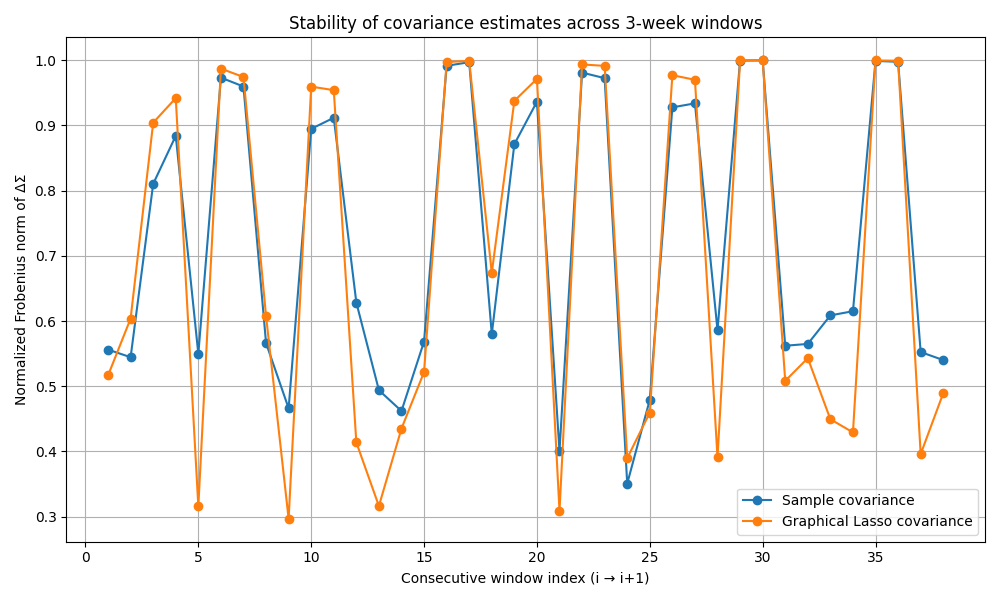

Stability comparison plot generated.


In [31]:
# Cell 6: Plot sample vs Glasso Frobenius norms

plt.figure(figsize=(10, 6))
x = np.arange(1, len(fro_sample) + 1)

plt.plot(x, fro_sample, marker='o', label="Sample covariance")
plt.plot(x, fro_glasso, marker='o', label="Graphical Lasso covariance")

plt.xlabel("Consecutive window index (i → i+1)")
plt.ylabel("Normalized Frobenius norm of ΔΣ")
plt.title(f"Stability of covariance estimates across {WINDOW_WEEKS}-week windows")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Stability comparison plot generated.")


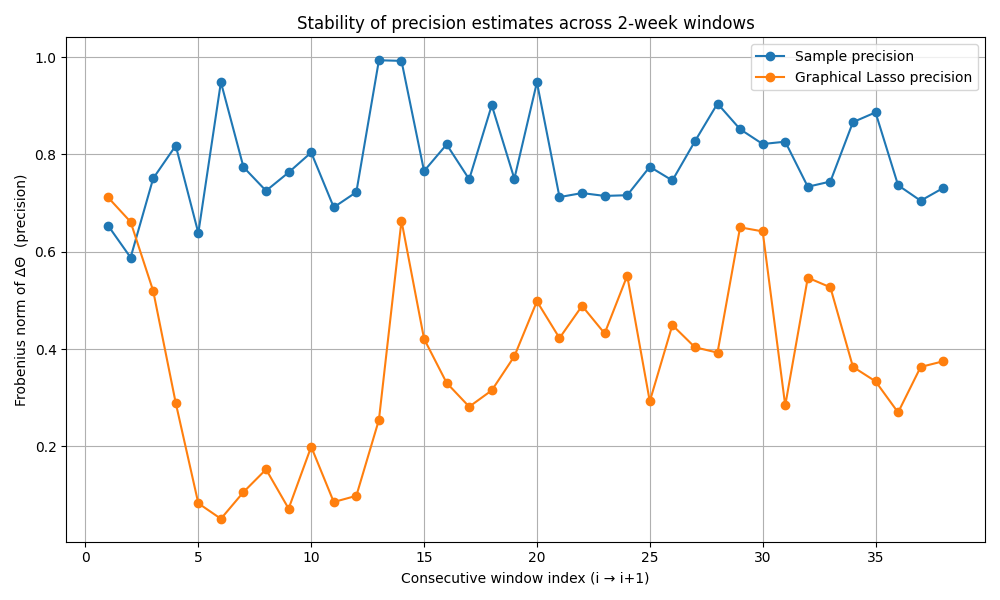

Frobenius differences between consecutive windows (PRECISION matrices):
  window_pair  frobenius_sample_prec  frobenius_glasso_prec
0         0→1               0.653870               0.711761
1         1→2               0.588160               0.661405
2         2→3               0.750750               0.519608
3         3→4               0.818108               0.289095
4         4→5               0.638527               0.083098

Summary statistics for precision matrices:
  mean(sample precision) : 0.7847035594670692
  mean(glasso precision) : 0.36760355835840236
  std(sample precision)  : 0.09464214885778739
  std(glasso precision)  : 0.18227079484561642
Precision stability comparison plot generated.
[0.65387046 0.58816005 0.75074959 0.81810766 0.63852692 0.94847444
 0.77396238 0.7253153  0.76303586 0.80407625 0.69136381 0.72256925
 0.99355389 0.99229221 0.76589041 0.82054085 0.74896449 0.9011972
 0.75004325 0.94818275 0.71239836 0.72064457 0.71477405 0.71620488
 0.77463338 0.7465154  

In [32]:
# Cell 7: Frobenius norm differences for precision matrices (sample vs Glasso)

# Reuse the same helper; it works for any list of matrices (covariances or precisions)
if any(prec is None for prec in sample_precs):
    print("Warning: Some sample precision matrices are None; Frobenius differences may be affected.")
else:
    fro_sample_prec = frobenius_differences(sample_precs)
    fro_glasso_prec = frobenius_differences(glasso_precs)

    # Label window pairs i -> i+1
    window_pairs_prec = [f"{i}→{i+1}" for i in range(len(fro_sample_prec))]

    prec_results_df = pd.DataFrame({
        "window_pair": window_pairs_prec,
        "frobenius_sample_prec": fro_sample_prec,
        "frobenius_glasso_prec": fro_glasso_prec,
    })
    # Plot the stability over window pairs
    plt.figure(figsize=(10, 6))
    x = np.arange(1, len(fro_sample_prec) + 1)

    plt.plot(x, fro_sample_prec, marker='o', label="Sample precision")
    plt.plot(x, fro_glasso_prec, marker='o', label="Graphical Lasso precision")

    plt.xlabel("Consecutive window index (i → i+1)")
    plt.ylabel("Frobenius norm of ΔΘ  (precision)")
    plt.title("Stability of precision estimates across 2-week windows")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Frobenius differences between consecutive windows (PRECISION matrices):")
    print(prec_results_df.head())

    print("\nSummary statistics for precision matrices:")
    print("  mean(sample precision) :", prec_results_df["frobenius_sample_prec"].mean())
    print("  mean(glasso precision) :", prec_results_df["frobenius_glasso_prec"].mean())
    print("  std(sample precision)  :", prec_results_df["frobenius_sample_prec"].std())
    print("  std(glasso precision)  :", prec_results_df["frobenius_glasso_prec"].std())

    print("Precision stability comparison plot generated.")


    print(fro_sample_prec)
    print(fro_glasso_prec)


Computing GMV (Markowitz min-var) portfolios and evaluating on next window...
Window 0->1: cumret Sample=0.1134, Glasso=-0.0039 | lev Sample=19.16, Glasso=1.00
Window 2: error computing GMV weights: Invalid A = 1' Theta 1. Precision matrix may be invalid.. Skipping.
Window 3: error computing GMV weights: Invalid A = 1' Theta 1. Precision matrix may be invalid.. Skipping.
Window 4: error computing GMV weights: Invalid A = 1' Theta 1. Precision matrix may be invalid.. Skipping.
Window 5: error computing GMV weights: Invalid A = 1' Theta 1. Precision matrix may be invalid.. Skipping.
Window 6: error computing GMV weights: Invalid A = 1' Theta 1. Precision matrix may be invalid.. Skipping.
Window 9: error computing GMV weights: Invalid A = 1' Theta 1. Precision matrix may be invalid.. Skipping.
Window 10: error computing GMV weights: Invalid A = 1' Theta 1. Precision matrix may be invalid.. Skipping.
Window 11: error computing GMV weights: Invalid A = 1' Theta 1. Precision matrix may be in

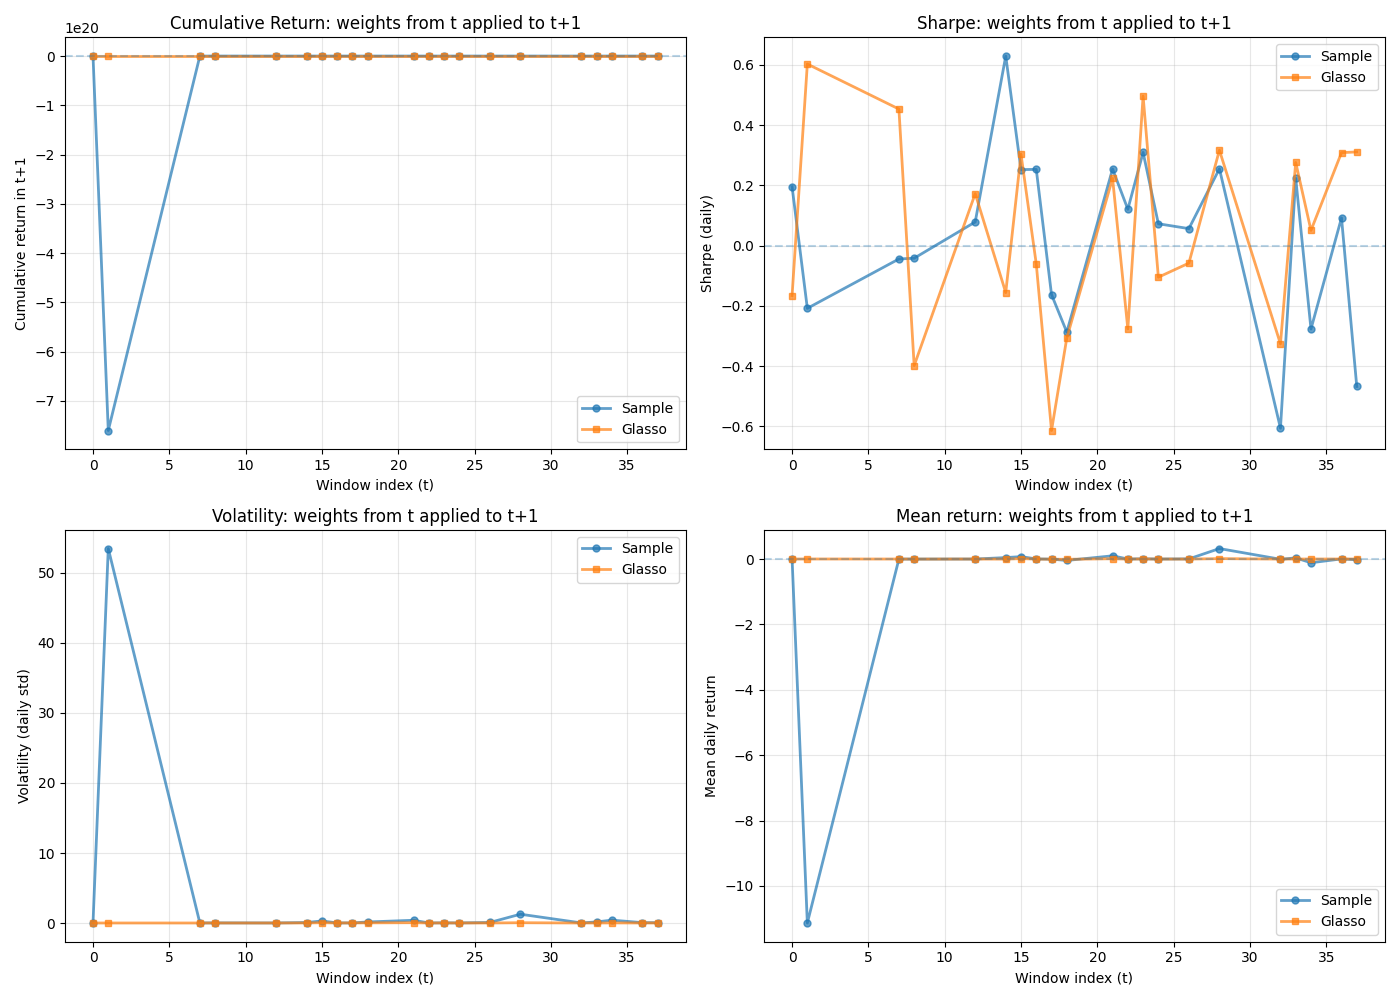

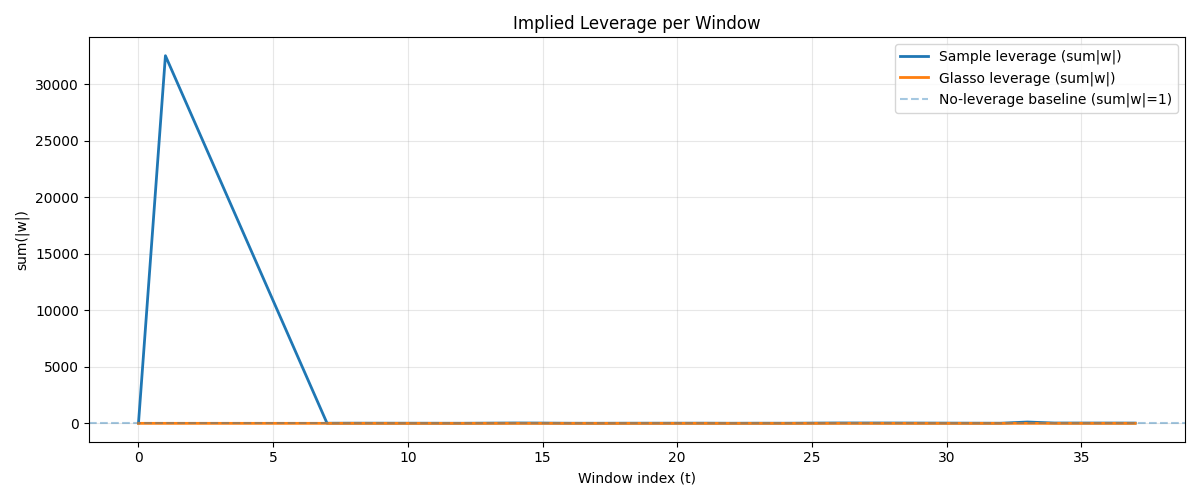

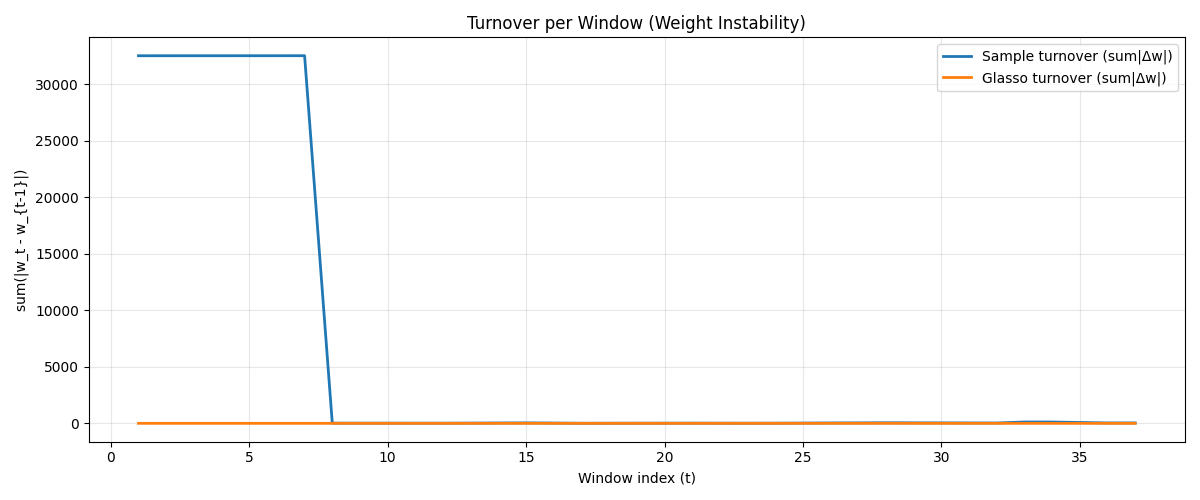

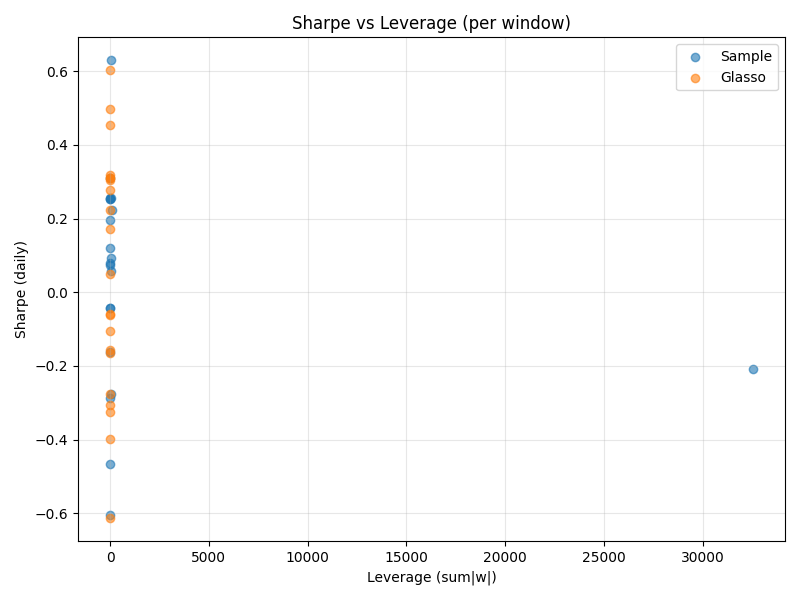

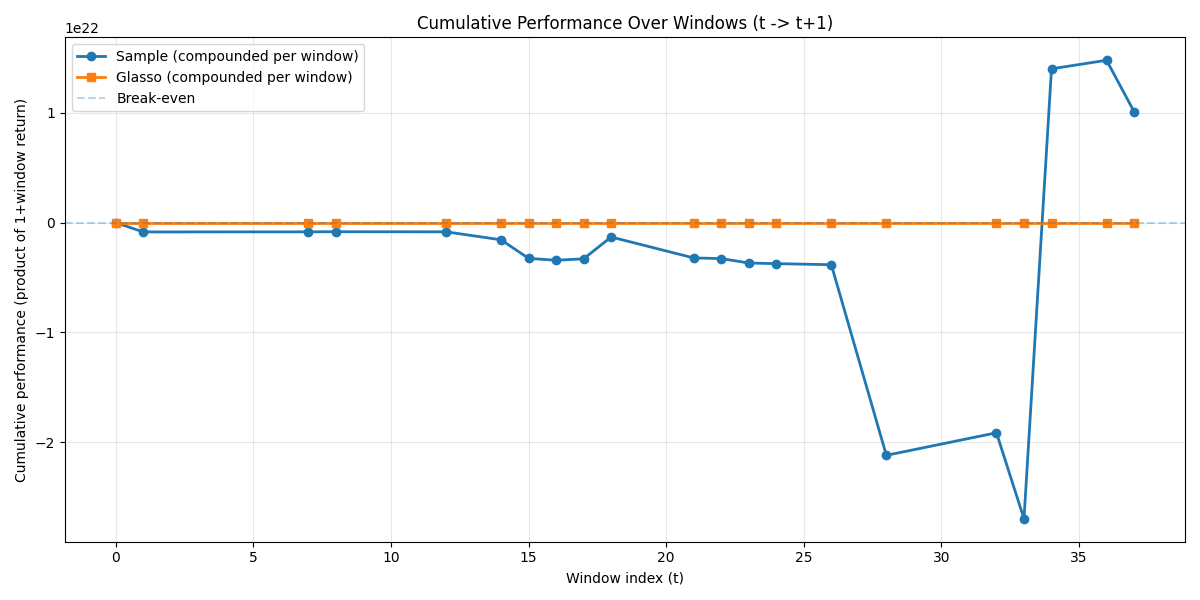


✅ GMV portfolio performance + leverage/turnover diagnostics complete!


In [28]:
# Cell 8: Markowitz (GMV) Portfolio Performance: Window t -> Window t+1
# Compare GMV using Sample (pseudo-inverse if needed) vs Glasso precision
# + Diagnostics to show "unnecessary risk": leverage (sum|w|) and turnover (sum|Δw|)

def min_variance_portfolio(Theta):
    """
    Global Minimum Variance portfolio under 1'w = 1, short-selling allowed.
    Uses only the precision matrix Theta = Sigma^{-1}.
    
    w* = Theta 1 / (1' Theta 1)
    """
    ones = np.ones(Theta.shape[0])
    A = ones @ Theta @ ones
    if A <= 0 or not np.isfinite(A):
        raise ValueError("Invalid A = 1' Theta 1. Precision matrix may be invalid.")
    w_mv = (Theta @ ones) / A
    return w_mv

def portfolio_returns(w, returns_df):
    """
    Compute portfolio daily returns for each day in returns_df (T x N).
    r_p = R @ w
    """
    if isinstance(returns_df, pd.DataFrame):
        if isinstance(w, pd.Series):
            w_aligned = w.reindex(returns_df.columns, fill_value=0.0).values
        else:
            w_aligned = np.asarray(w)
        return (returns_df.values @ w_aligned).flatten()
    else:
        return (np.asarray(returns_df) @ np.asarray(w)).flatten()

def get_sample_precision(t):
    """
    Return a usable precision matrix for the sample estimator at window t.
    If precomputed inverse is missing (None), fall back to pseudo-inverse of sample covariance.
    """
    prec = sample_precs[t]
    if prec is None:
        cov = sample_covs[t]
        prec = np.linalg.pinv(cov)
    return prec

# -----------------------------
# Storage for results
# -----------------------------
results = {
    "window_idx": [],

    # Out-of-sample performance on window t+1
    "sample_cumulative_return": [],
    "glasso_cumulative_return": [],
    "sample_sharpe": [],
    "glasso_sharpe": [],
    "sample_volatility": [],
    "glasso_volatility": [],
    "sample_mean_return": [],
    "glasso_mean_return": [],

    # Diagnostics (risk / instability)
    "sample_leverage_L1": [],     # sum |w|
    "glasso_leverage_L1": [],
    "sample_turnover_L1": [],     # sum |w_t - w_{t-1}|
    "glasso_turnover_L1": [],
}

print("Computing GMV (Markowitz min-var) portfolios and evaluating on next window...")
print("=" * 70)

# We'll keep previous weights to compute turnover
prev_w_sample = None
prev_w_glasso = None

# Iterate over windows (skip last window as there's no t+1)
for t in range(len(windows) - 1):
    window_t = windows[t]
    window_t1 = windows[t + 1]

    # Ensure same asset universe in t and t+1
    if not window_t.columns.equals(window_t1.columns):
        print(f"Warning: Window {t} and {t+1} have different assets. Skipping (would need recompute covariances).")
        continue

    # Get precision matrices for window t
    try:
        sample_prec_t = get_sample_precision(t)
        glasso_prec_t = glasso_precs[t]
    except Exception as e:
        print(f"Window {t}: could not retrieve precision matrices: {e}. Skipping.")
        continue

    # Compute GMV weights
    try:
        w_sample = min_variance_portfolio(sample_prec_t)
        w_glasso = min_variance_portfolio(glasso_prec_t)
    except Exception as e:
        print(f"Window {t}: error computing GMV weights: {e}. Skipping.")
        continue

    # Diagnostics: leverage (sum|w|)
    lev_sample = float(np.sum(np.abs(w_sample)))
    lev_glasso = float(np.sum(np.abs(w_glasso)))

    # Diagnostics: turnover (sum|Δw|)
    if prev_w_sample is None:
        to_sample = np.nan
        to_glasso = np.nan
    else:
        to_sample = float(np.sum(np.abs(w_sample - prev_w_sample)))
        to_glasso = float(np.sum(np.abs(w_glasso - prev_w_glasso)))

    # Apply weights to window t+1 returns (out-of-sample)
    w_sample_series = pd.Series(w_sample, index=window_t.columns)
    w_glasso_series = pd.Series(w_glasso, index=window_t.columns)

    portfolio_ret_sample = portfolio_returns(w_sample_series, window_t1)
    portfolio_ret_glasso = portfolio_returns(w_glasso_series, window_t1)

    # Performance metrics (daily)
    cumret_sample = float(np.prod(1.0 + portfolio_ret_sample) - 1.0)
    cumret_glasso = float(np.prod(1.0 + portfolio_ret_glasso) - 1.0)

    meanret_sample = float(np.mean(portfolio_ret_sample))
    meanret_glasso = float(np.mean(portfolio_ret_glasso))

    # Use ddof=1 for sample std (more standard); keep ddof=0 if you prefer
    vol_sample = float(np.std(portfolio_ret_sample, ddof=1))
    vol_glasso = float(np.std(portfolio_ret_glasso, ddof=1))

    # Sharpe (daily), rf=0
    sharpe_sample = (meanret_sample / vol_sample) if vol_sample > 1e-12 else 0.0
    sharpe_glasso = (meanret_glasso / vol_glasso) if vol_glasso > 1e-12 else 0.0

    # Store results
    results["window_idx"].append(t)

    results["sample_cumulative_return"].append(cumret_sample)
    results["glasso_cumulative_return"].append(cumret_glasso)

    results["sample_sharpe"].append(sharpe_sample)
    results["glasso_sharpe"].append(sharpe_glasso)

    results["sample_volatility"].append(vol_sample)
    results["glasso_volatility"].append(vol_glasso)

    results["sample_mean_return"].append(meanret_sample)
    results["glasso_mean_return"].append(meanret_glasso)

    results["sample_leverage_L1"].append(lev_sample)
    results["glasso_leverage_L1"].append(lev_glasso)

    results["sample_turnover_L1"].append(to_sample)
    results["glasso_turnover_L1"].append(to_glasso)

    # Update previous weights
    prev_w_sample = w_sample
    prev_w_glasso = w_glasso

    if (t + 1) % 5 == 0 or t == 0:
        print(f"Window {t}->{t+1}: cumret Sample={cumret_sample:.4f}, Glasso={cumret_glasso:.4f} | "
              f"lev Sample={lev_sample:.2f}, Glasso={lev_glasso:.2f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

if len(results_df) == 0:
    print("\n⚠️  No results computed. Check for warnings above.")
else:
    print("\n" + "=" * 70)
    print("Summary Statistics (per-window OOS on t+1)")
    print("=" * 70)

    print("\nSample (pseudo-inverse if needed):")
    print(f"  Mean cumulative return: {results_df['sample_cumulative_return'].mean():.6f}")
    print(f"  Std cumulative return:  {results_df['sample_cumulative_return'].std():.6f}")
    print(f"  Mean Sharpe (daily):     {results_df['sample_sharpe'].mean():.4f}")
    print(f"  Mean volatility (daily): {results_df['sample_volatility'].mean():.6f}")
    print(f"  Mean leverage (sum|w|):  {results_df['sample_leverage_L1'].mean():.2f}")
    print(f"  Mean turnover (sum|Δw|): {results_df['sample_turnover_L1'].dropna().mean():.2f}")

    print("\nGlasso:")
    print(f"  Mean cumulative return: {results_df['glasso_cumulative_return'].mean():.6f}")
    print(f"  Std cumulative return:  {results_df['glasso_cumulative_return'].std():.6f}")
    print(f"  Mean Sharpe (daily):     {results_df['glasso_sharpe'].mean():.4f}")
    print(f"  Mean volatility (daily): {results_df['glasso_volatility'].mean():.6f}")
    print(f"  Mean leverage (sum|w|):  {results_df['glasso_leverage_L1'].mean():.2f}")
    print(f"  Mean turnover (sum|Δw|): {results_df['glasso_turnover_L1'].dropna().mean():.2f}")

    x = results_df["window_idx"]

    # -----------------------------
    # Plot A: Performance (same as before)
    # -----------------------------
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = axes[0, 0]
    ax1.plot(x, results_df["sample_cumulative_return"], marker="o", label="Sample", linewidth=2, markersize=5, alpha=0.7)
    ax1.plot(x, results_df["glasso_cumulative_return"], marker="s", label="Glasso", linewidth=2, markersize=5, alpha=0.7)
    ax1.axhline(0, linestyle="--", alpha=0.3)
    ax1.set_xlabel("Window index (t)")
    ax1.set_ylabel("Cumulative return in t+1")
    ax1.set_title("Cumulative Return: weights from t applied to t+1")
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2 = axes[0, 1]
    ax2.plot(x, results_df["sample_sharpe"], marker="o", label="Sample", linewidth=2, markersize=5, alpha=0.7)
    ax2.plot(x, results_df["glasso_sharpe"], marker="s", label="Glasso", linewidth=2, markersize=5, alpha=0.7)
    ax2.axhline(0, linestyle="--", alpha=0.3)
    ax2.set_xlabel("Window index (t)")
    ax2.set_ylabel("Sharpe (daily)")
    ax2.set_title("Sharpe: weights from t applied to t+1")
    ax2.legend()
    ax2.grid(alpha=0.3)

    ax3 = axes[1, 0]
    ax3.plot(x, results_df["sample_volatility"], marker="o", label="Sample", linewidth=2, markersize=5, alpha=0.7)
    ax3.plot(x, results_df["glasso_volatility"], marker="s", label="Glasso", linewidth=2, markersize=5, alpha=0.7)
    ax3.set_xlabel("Window index (t)")
    ax3.set_ylabel("Volatility (daily std)")
    ax3.set_title("Volatility: weights from t applied to t+1")
    ax3.legend()
    ax3.grid(alpha=0.3)

    ax4 = axes[1, 1]
    ax4.plot(x, results_df["sample_mean_return"], marker="o", label="Sample", linewidth=2, markersize=5, alpha=0.7)
    ax4.plot(x, results_df["glasso_mean_return"], marker="s", label="Glasso", linewidth=2, markersize=5, alpha=0.7)
    ax4.axhline(0, linestyle="--", alpha=0.3)
    ax4.set_xlabel("Window index (t)")
    ax4.set_ylabel("Mean daily return")
    ax4.set_title("Mean return: weights from t applied to t+1")
    ax4.legend()
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Plot B: Diagnostics to show "unnecessary risk"
    # -----------------------------
    plt.figure(figsize=(12, 5))
    plt.plot(x, results_df["sample_leverage_L1"], label="Sample leverage (sum|w|)", linewidth=2)
    plt.plot(x, results_df["glasso_leverage_L1"], label="Glasso leverage (sum|w|)", linewidth=2)
    plt.axhline(1.0, linestyle="--", alpha=0.4, label="No-leverage baseline (sum|w|=1)")
    plt.title("Implied Leverage per Window")
    plt.xlabel("Window index (t)")
    plt.ylabel("sum(|w|)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(x, results_df["sample_turnover_L1"], label="Sample turnover (sum|Δw|)", linewidth=2)
    plt.plot(x, results_df["glasso_turnover_L1"], label="Glasso turnover (sum|Δw|)", linewidth=2)
    plt.title("Turnover per Window (Weight Instability)")
    plt.xlabel("Window index (t)")
    plt.ylabel("sum(|w_t - w_{t-1}|)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Scatter: Sharpe vs Leverage (per-window)
    df_sc = results_df.dropna(subset=["sample_leverage_L1", "glasso_leverage_L1", "sample_sharpe", "glasso_sharpe"]).copy()

    plt.figure(figsize=(8, 6))
    plt.scatter(df_sc["sample_leverage_L1"], df_sc["sample_sharpe"], alpha=0.6, label="Sample")
    plt.scatter(df_sc["glasso_leverage_L1"], df_sc["glasso_sharpe"], alpha=0.6, label="Glasso")
    plt.xlabel("Leverage (sum|w|)")
    plt.ylabel("Sharpe (daily)")
    plt.title("Sharpe vs Leverage (per window)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Plot C: Cumulative over windows (as in your original cell)
    # NOTE: This compounds per-window cumulative returns. If your windows overlap,
    # this is not a true daily equity curve.
    # -----------------------------
    cumulative_sample = np.cumprod(1.0 + results_df["sample_cumulative_return"].values)
    cumulative_glasso = np.cumprod(1.0 + results_df["glasso_cumulative_return"].values)

    plt.figure(figsize=(12, 6))
    plt.plot(x, cumulative_sample, marker="o", label="Sample (compounded per window)", linewidth=2)
    plt.plot(x, cumulative_glasso, marker="s", label="Glasso (compounded per window)", linewidth=2)
    plt.axhline(1.0, linestyle="--", alpha=0.3, label="Break-even")
    plt.xlabel("Window index (t)")
    plt.ylabel("Cumulative performance (product of 1+window return)")
    plt.title("Cumulative Performance Over Windows (t -> t+1)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n✅ GMV portfolio performance + leverage/turnover diagnostics complete!")

# 📊 Markowitz GMV with Sample vs Graphical Lasso  
### Stability, Risk Diagnostics, and Out-of-Sample Behavior

This notebook compares **two estimators of the covariance / precision matrix** in a **Global Minimum Variance (GMV) Markowitz portfolio** framework:

* **Sample covariance** (and its inverse / pseudo-inverse)
* **Graphical Lasso (Glasso)** covariance and precision

The goal is **not** to maximize returns, but to study **stability, numerical robustness, and economically meaningful risk diagnostics** in a high-dimensional setting.

---

## 🧠 Context: Why This Experiment Matters

In realistic financial problems we often have:
* **Many assets ($N$ large)**
* **Few observations per window ($T$ small)** This leads to:
* Ill-conditioned or singular sample covariance matrices.
* Extremely unstable portfolio weights.
* Large estimation error amplified by matrix inversion.

Regularization methods like **Graphical Lasso** are designed to address these issues by promoting sparsity in the precision matrix.

---

## 📐 Global Minimum Variance (GMV) Portfolio

We focus on the **GMV portfolio**, defined as:

$$\min_w \; w^\top \Sigma w \quad \text{s.t. } \mathbf{1}^\top w = 1$$

Its closed-form solution depends **only on the precision matrix**:

$$w^* = \frac{\Theta \mathbf{1}}{\mathbf{1}^\top \Theta \mathbf{1}}, \quad \Theta = \Sigma^{-1}$$

This makes GMV an ideal testbed to compare covariance estimators:
* Any instability in $\Theta$ directly translates into unstable weights.

---

## 🔁 Rolling Windows and Out-of-Sample Evaluation

For each rolling window $t$:

1. Estimate covariance / precision using data in window $t$.
2. Compute GMV weights using that estimate.
3. Apply the weights to **returns in window $t+1$** (out-of-sample).
4. Measure performance and stability diagnostics.

This avoids in-sample bias and reveals how estimation error propagates forward.

---

## 📊 Quantities We Compute and Why They Matter

### 1️⃣ Cumulative Return (Out-of-Sample)

$$\prod_{i \in t+1} (1 + r_{p,i}) - 1$$

* Measures realized performance using weights estimated at time $t$.
* Not the main objective here, but useful as a sanity check.

---

### 2️⃣ Mean Return and Volatility

* **Mean daily return**: average performance in window $t+1$.
* **Volatility**: standard deviation of daily portfolio returns.

Used mainly to compute the Sharpe ratio.

---

### 3️⃣ Sharpe Ratio (Daily, $rf = 0$)

$$\text{Sharpe} = \frac{\mathbb{E}[r_p]}{\sigma_p}$$

* A risk-adjusted performance metric.
* In this experiment, Sharpe is **secondary** to stability diagnostics.
* GMV portfolios are not designed to maximize Sharpe.

---

## ⚠️ Stability and "Unnecessary Risk" Diagnostics

These are the **most important quantities** in this notebook.

### 4️⃣ Leverage (L1 Norm of Weights)

$$\text{Leverage} = \sum_i |w_i|$$

**Interpretation:**
* $= 1$: no leverage (long-only baseline).
* $> 1$: implicit leverage via long–short positions.
* Very large values indicate **extreme and fragile portfolios**.

**Expectation:**
* Sample covariance $\rightarrow$ very high leverage.
* Glasso $\rightarrow$ significantly lower and more stable leverage.

---

### 5️⃣ Turnover (Weight Instability)

$$\text{Turnover}_t = \sum_i |w_{t,i} - w_{t-1,i}|$$

**Interpretation:**
* Measures how much the portfolio changes between windows.
* Proxy for transaction costs and model instability.

**Expectation:**
* Sample GMV $\rightarrow$ large, erratic turnover.
* Glasso GMV $\rightarrow$ smoother weight evolution.

---

## 🔢 Frobenius Norm Differences

We also compute:

$$\frac{\|\Sigma_{t+1} - \Sigma_t\|_F}{\|\Sigma_t\|_F} \quad \text{and} \quad \frac{\|\Theta_{t+1} - \Theta_t\|_F}{\|\Theta_t\|_F}$$

**Purpose:**
* Quantify how sensitive covariance and precision estimates are to small data changes.
* Connect numerical conditioning to portfolio instability.

---

## 🔬 What We Expect: Sample vs Graphical Lasso

| Feature | Sample Covariance | Graphical Lasso |
| :--- | :--- | :--- |
| **Conditioning** | Often ill-conditioned/singular | Well-conditioned (regularized) |
| **Precision ($\Theta$)** | Extremely unstable | Sparse and stable |
| **Leverage** | Exploding | Controlled |
| **Turnover** | High (reacts to noise) | Low (reacts to signal) |

---

## 🎯 Key Takeaway

> **Graphical Lasso is not primarily about increasing returns. Its real value is reducing estimation-induced risk, stabilizing portfolio weights, and producing economically meaningful solutions in high-dimensional settings.**

Now we try to use more hystorical data and we evaluate the performance in long periods

[*********************100%***********************]  100 of 100 completed


Kept 91 / 100 tickers with >= 95% coverage
Dropped 254 days with missing data; 787 days remain
✅ Retrieved 91 assets over 787 days
Train window: 2021-01-05 -> 2023-12-29
Test window : 2024-01-02 -> 2024-12-30
Final value - Sample: 1.1238108347322422
Final value - Glasso: 1.140320175894527


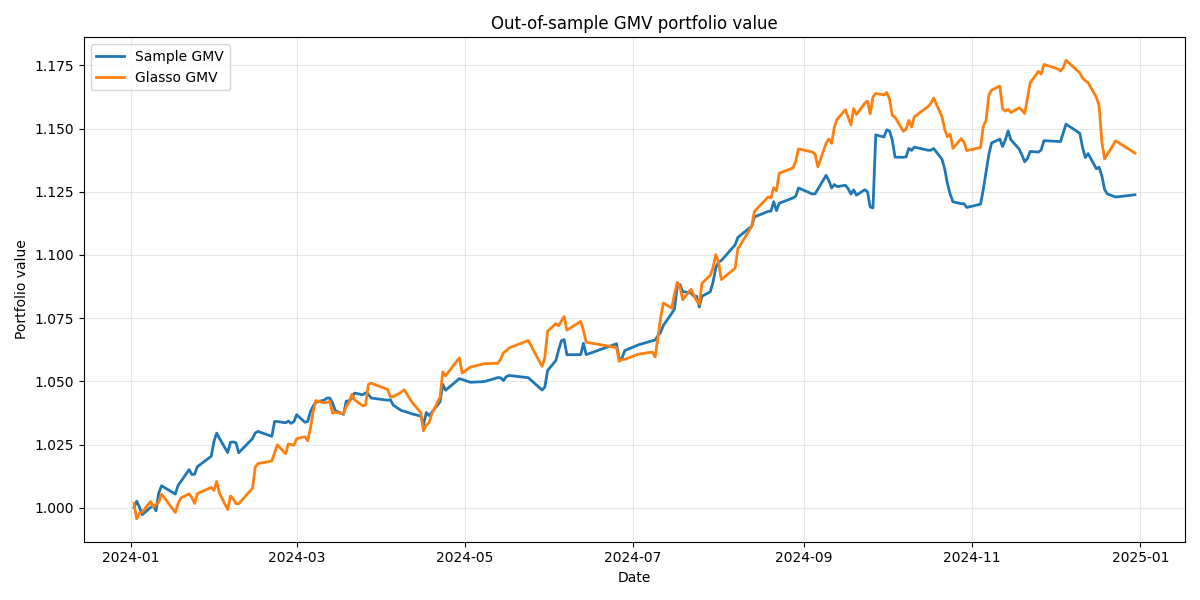

In [29]:
# Cell 9: Fixed train/test split (out-of-sample) with GMV portfolios
OOS_START_DATE = "2021-01-01"
OOS_END_DATE = "2025-01-01"
TRAIN_YEARS = 3
TEST_YEARS = 1

oos_start = pd.Timestamp(OOS_START_DATE)
oos_end = pd.Timestamp(OOS_END_DATE)
train_end = oos_start + pd.DateOffset(years=TRAIN_YEARS)
test_end = train_end + pd.DateOffset(years=TEST_YEARS)

if test_end > oos_end:
    raise ValueError(
        "Not enough data for TRAIN_YEARS + TEST_YEARS inside the date range."
    )

# Use existing returns_df if it already covers the range; otherwise download.
use_existing = "returns_df" in globals()
if use_existing:
    try:
        has_coverage = returns_df.index.min() <= oos_start and returns_df.index.max() >= test_end
        use_existing = bool(has_coverage)
    except Exception:
        use_existing = False

if use_existing:
    returns_full = returns_df.copy()
else:
    returns_full = get_data(
        TICKERS,
        OOS_START_DATE,
        OOS_END_DATE,
        min_coverage=0.95,
        fill_nan=False,
        save=False,
    )

returns_full = returns_full.loc[oos_start:oos_end].copy()

train_mask = (returns_full.index >= oos_start) & (returns_full.index < train_end)
test_mask = (returns_full.index >= train_end) & (returns_full.index < test_end)

train_returns = returns_full.loc[train_mask]
test_returns = returns_full.loc[test_mask]

if train_returns.empty or test_returns.empty:
    raise ValueError("Train/test split is empty. Check dates or data coverage.")

# Sample covariance and precision
sample_cov = train_returns.cov().values
sample_prec = np.linalg.pinv(sample_cov)

# Glasso covariance and precision
glasso_cov, glasso_prec = glasso(
    alpha=ALPHA,
    returns_df=train_returns,
    save_outputs=False,
    max_iter=200,
)

# GMV weights (use existing helper if defined)
if "min_variance_portfolio" not in globals():
    def min_variance_portfolio(Theta):
        ones = np.ones(Theta.shape[0])
        A = ones @ Theta @ ones
        if A <= 0 or not np.isfinite(A):
            raise ValueError("Invalid A = 1' Theta 1. Precision matrix may be invalid.")
        return (Theta @ ones) / A

w_sample = min_variance_portfolio(sample_prec)
w_glasso = min_variance_portfolio(glasso_prec)

w_sample = pd.Series(w_sample, index=train_returns.columns)
w_glasso = pd.Series(w_glasso, index=train_returns.columns)

# Out-of-sample portfolio values
test_returns = test_returns.loc[:, train_returns.columns]
ret_sample = test_returns.values @ w_sample.values
ret_glasso = test_returns.values @ w_glasso.values

value_sample = pd.Series((1.0 + ret_sample).cumprod(), index=test_returns.index, name="Sample")
value_glasso = pd.Series((1.0 + ret_glasso).cumprod(), index=test_returns.index, name="Glasso")

print("Train window:", train_returns.index.min().date(), "->", train_returns.index.max().date())
print("Test window :", test_returns.index.min().date(), "->", test_returns.index.max().date())
print("Final value - Sample:", value_sample.iloc[-1])
print("Final value - Glasso:", value_glasso.iloc[-1])

plt.figure(figsize=(12, 6))
plt.plot(value_sample.index, value_sample.values, label="Sample GMV", linewidth=2)
plt.plot(value_glasso.index, value_glasso.values, label="Glasso GMV", linewidth=2)
plt.title("Out-of-sample GMV portfolio value")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
